#Support Vector Machine - Defence dataset

**Use of the Scenario:**

1. Imagine soldiers deployed in Kashmir-type high-altitude borders during harsh winters.

2. Some soldiers develop cold-related injuries (frostbite, hypothermia).

3. Officers want a predictive model that, given certain risk factors, can classify a soldier’s risk level (Low / Medium / High).

**We classify,**

1. Low risk – soldier unlikely to get cold-related injuries

2. Medium risk – moderate probability

3.High risk – soldier is very vulnerable and requires preventive action (better gear, less exposure, medical monitoring)

In [83]:
# Install interactive widgets (if not already installed in Colab)
!pip install ipywidgets

#import libraries and read the dataset

In [84]:
# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import ipywidgets as widgets
from IPython.display import display, clear_output

# 2) Read dataset into DataFrame
# Ensure casualties_winter.csv is uploaded into the Colab working directory
df = pd.read_csv("/content/casualties_winter.csv")
print("Dataset shape:", df.shape)
display(df.head())



Dataset shape: (400, 7)


,age,BMI,cold_gear_quality,exposure_hours,previous_injury,snow_depth,risk_level
0,36,22.4,poor,28,0,80,medium
1,38,21.8,average,32,1,105,low
2,29,27.0,good,28,0,156,low
3,35,23.2,good,9,0,11,medium
4,21,19.1,poor,45,0,19,high


# Data preprocessing (Missing Values, fill the missing values, encoding categorical features)

In [85]:
# -----------------------
# Expected columns (example):
# age, BMI, cold_gear_quality, exposure_hours, previous_injury, snow_depth, risk_level
# -----------------------

# 3) Basic preprocessing
#  - Inspect missing values
print("\nMissing values per column:")
print(df.isna().sum())

# If there are any missing values, simple fill (median for numeric, mode for categorical)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# If target in cat_cols, keep it separate
target_col = "risk_level"
if target_col in cat_cols:
    cat_cols.remove(target_col)

# Fill missing for numeric and categorical (robust for synthetic data)
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode()[0])

# Encode categorical features (cold_gear_quality) and target
encoders = {}
for c in cat_cols + [target_col]:
    enc = LabelEncoder()
    df[c] = enc.fit_transform(df[c])
    encoders[c] = enc

print("\nLabel encoder classes:")
for k,v in encoders.items():
    print(f"{k}: {v.classes_}")




Missing values per column:
age                  0
BMI                  0
cold_gear_quality    0
exposure_hours       0
previous_injury      0
snow_depth           0
risk_level           0
dtype: int64

Label encoder classes:
cold_gear_quality: ['average' 'good' 'poor']
risk_level: ['high' 'low' 'medium']


# Select the features and scale them

In [86]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Standardize numerical features (SVM benefits from scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



# Exploratory Data Analysis


Class distribution (target):


,risk_level,count
0,1,142
1,2,134
2,0,124


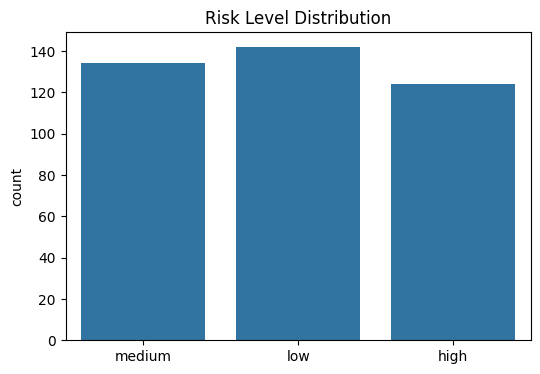

In [87]:
# 4) Exploratory Data Analysis (EDA)
print("\nClass distribution (target):")
display(df[target_col].value_counts().rename_axis('risk_level').reset_index(name='count'))

# Visuals
plt.figure(figsize=(6,4))
sns.countplot(x=encoders[target_col].inverse_transform(df[target_col]))
plt.title("Risk Level Distribution")
plt.show()



Pair plot

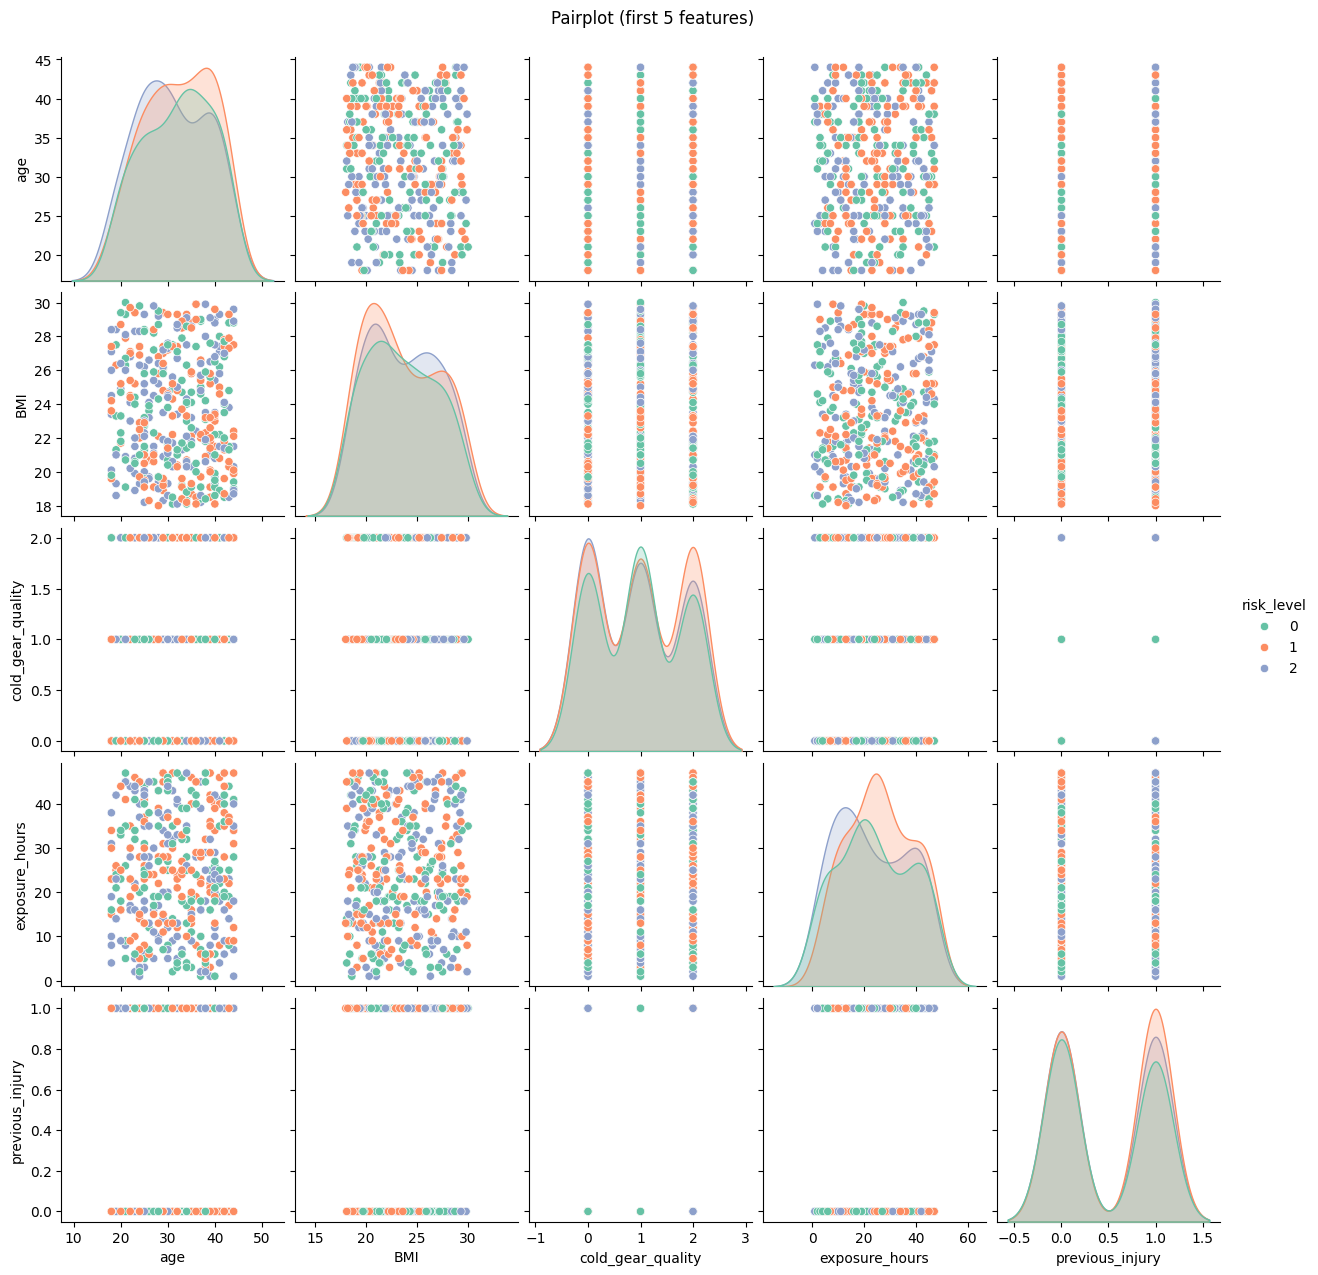

In [88]:
# Pairplot for a subset (avoid too many features)
subset_cols = X.columns.tolist()[:5]  # first few features for pairplot
sns.pairplot(pd.concat([df[subset_cols], df[target_col]], axis=1),
             hue=target_col, palette="Set2")
plt.suptitle("Pairplot (first 5 features)", y=1.02)
plt.show()



Correlation Map

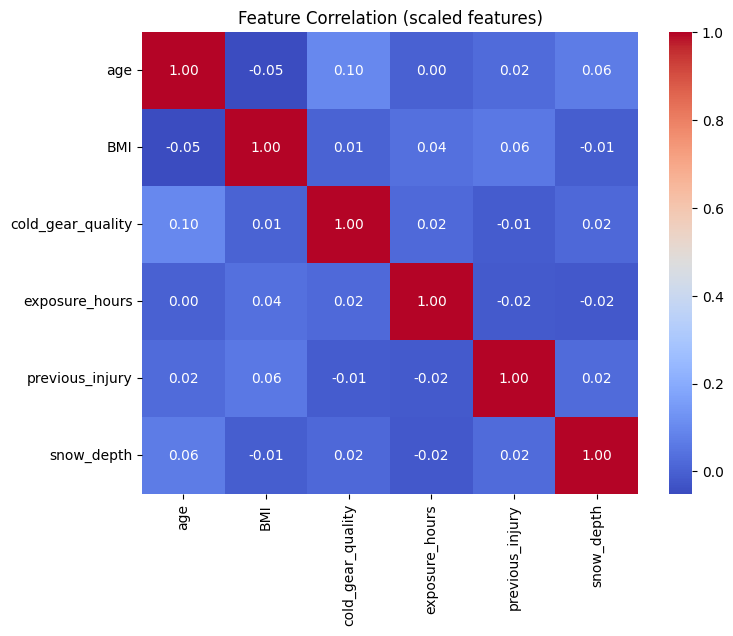

In [89]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(X_scaled, columns=X.columns).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation (scaled features)")
plt.show()



#Split the dataset and train a model with various hyperparameters

In [90]:
# 5) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTrain / Test sizes:", X_train.shape[0], X_test.shape[0])

# 6) Train SVM with various hyperparameters (Grid Search)
# We'll test three kernels and some C/gamma/degree combos
param_grid = [
    {"kernel": ["linear"], "C": [0.1, 1, 10]},
    {"kernel": ["rbf"], "C": [0.1, 1, 10], "gamma": ["scale", 0.01, 0.1, 1]},
    {"kernel": ["poly"], "C": [0.1, 1], "degree": [2, 3], "gamma": ["scale", 0.1]},
]

svc = SVC(probability=False)  # probability=True if you need predict_proba (slower)
grid = GridSearchCV(svc, param_grid, scoring="accuracy", cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("\nBest hyperparameters found:")
print(grid.best_params_)
print("Best CV accuracy: {:.4f}".format(grid.best_score_))




Train / Test sizes: 320 80
Fitting 5 folds for each of 23 candidates, totalling 115 fits

Best hyperparameters found:
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV accuracy: 0.3969


#Metrics and Evaluation

Best parameter accuracy results

In [91]:
# 7) Show accuracy results (sorted)
results = pd.DataFrame(grid.cv_results_)
cols = ["params", "mean_test_score", "std_test_score"]
display(results[cols].sort_values("mean_test_score", ascending=False).head(20))



,params,mean_test_score,std_test_score
9,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.396875,0.081250
21,"{'C': 1, 'degree': 3, 'gamma': 'scale', 'kerne...",0.396875,0.043750
2,"{'C': 10, 'kernel': 'linear'}",0.378125,0.065102
11,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.378125,0.058797
12,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.375000,0.053217
1,"{'C': 1, 'kernel': 'linear'}",0.375000,0.067748
7,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.375000,0.077182
17,"{'C': 0.1, 'degree': 3, 'gamma': 'scale', 'ker...",0.365625,0.042619
6,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.356250,0.006250
4,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",0.356250,0.006250


Best Test Results

In [92]:
# 8) Test the best model on hold-out test set
best_svm = grid.best_estimator_
y_pred = best_svm.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("\nTest set accuracy of best SVM: {:.4f}".format(test_acc))




Test set accuracy of best SVM: 0.3000


Classification Report and Confusion Matrix


Classification Report (test set):
              precision    recall  f1-score   support

        high       0.33      0.12      0.18        25
         low       0.27      0.46      0.34        28
      medium       0.35      0.30      0.32        27

    accuracy                           0.30        80
   macro avg       0.32      0.29      0.28        80
weighted avg       0.32      0.30      0.28        80



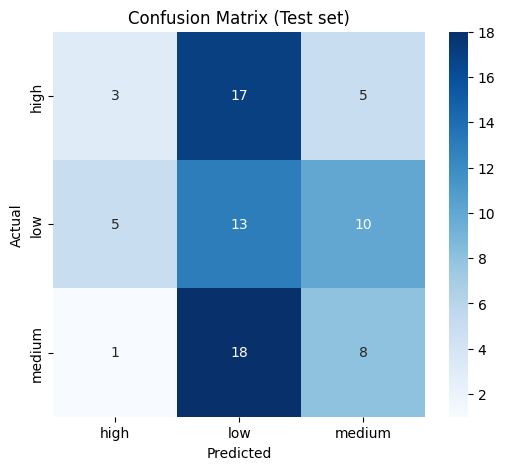

In [93]:
# 9) Metrics: classification report & confusion matrix
print("\nClassification Report (test set):")
target_names = encoders[target_col].classes_
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test set)")
plt.show()



Manual Validation

In [94]:
# 10) Manual validation - test model with manual input(s)
def manual_predict(age, BMI, cold_gear_quality, exposure_hours, previous_injury, snow_depth):
    # Build DataFrame with same columns order as X
    sample = pd.DataFrame([{
        col: None for col in X.columns
    }])
    # Fill values (note: if your dataset has different numeric ranges you can adjust)
    sample[X.columns[0]] = age
    sample[X.columns[1]] = BMI
    # cold_gear_quality is categorical encoded earlier
    if "cold_gear_quality" in encoders:
        sample["cold_gear_quality"] = encoders["cold_gear_quality"].transform([cold_gear_quality])[0]
    else:
        # if not present, assume value provided numeric
        sample["cold_gear_quality"] = cold_gear_quality
    sample["exposure_hours"] = exposure_hours
    sample["previous_injury"] = previous_injury
    sample["snow_depth"] = snow_depth

    # Ensure numeric dtype and reorder to columns
    sample = sample.astype(float)[X.columns]
    # scale
    sample_scaled = scaler.transform(sample)
    pred = best_svm.predict(sample_scaled)
    pred_label = encoders[target_col].inverse_transform(pred)[0]
    return pred_label

# Example manual test
example = manual_predict(age=28, BMI=22.5, cold_gear_quality=encoders["cold_gear_quality"].classes_[1],
                         exposure_hours=6, previous_injury=0, snow_depth=60)
print("\nExample manual prediction -> Risk Level:", example)


Example manual prediction -> Risk Level: medium


Using interactive widgets

In [95]:
# 11) Interactive widgets for live testing in the workshop
# Build widgets: numeric sliders and categorical dropdown for cold_gear_quality
cold_gear_options = encoders["cold_gear_quality"].classes_.tolist() if "cold_gear_quality" in encoders else ["poor","average","good"]
age_slider = widgets.IntSlider(min=18, max=60, step=1, value=28, description="Age")
bmi_slider = widgets.FloatSlider(min=15.0, max=40.0, step=0.1, value=22.5, description="BMI")
cold_dropdown = widgets.Dropdown(options=cold_gear_options, value=cold_gear_options[0], description="Cold Gear")
exposure_slider = widgets.IntSlider(min=0, max=72, step=1, value=6, description="Exposure hrs")
prev_inj_toggle = widgets.ToggleButtons(options=[0,1], value=0, description="Prev Injury (0/1)")
snow_slider = widgets.IntSlider(min=0, max=300, step=1, value=60, description="Snow depth (cm)")

out = widgets.Output()

def on_change_predict(change=None):
    with out:
        clear_output(wait=True)
        # Map categorical selection to encoded value
        cold_sel = cold_dropdown.value
        pred = manual_predict(
            age=age_slider.value,
            BMI=bmi_slider.value,
            cold_gear_quality=cold_sel,
            exposure_hours=exposure_slider.value,
            previous_injury=prev_inj_toggle.value,
            snow_depth=snow_slider.value
        )
        print("Predicted Risk Level:", pred)
        # optionally show probability if you re-train with probability=True
        # proba = best_svm.predict_proba(sample_scaled)
        # print("Class probabilities:", proba)

# Wire up widget changes
controls = widgets.VBox([age_slider, bmi_slider, cold_dropdown, exposure_slider, prev_inj_toggle, snow_slider])
display(controls, out)
# Attach handler
age_slider.observe(on_change_predict, names='value')
bmi_slider.observe(on_change_predict, names='value')
cold_dropdown.observe(on_change_predict, names='value')
exposure_slider.observe(on_change_predict, names='value')
prev_inj_toggle.observe(on_change_predict, names='value')
snow_slider.observe(on_change_predict, names='value')

# Initial prediction display
on_change_predict()
# ===================================================================


Output()